In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="You are using `torch.load` with `weights_only=False`")
warnings.filterwarnings("ignore", category=UserWarning, message="The PyTorch API of nested tensors is in prototype stage and will change in the near future.")

%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0,"/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre")
            
import torch
torch.set_printoptions(precision=10)


import yaml
torch.set_float32_matmul_precision('high')
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw
# load model 
from datasets.dataset_utils import  FP_Loader_Configer
fp_loader_configer = FP_Loader_Configer()

fp_loader_configer.select_version("MFP_Specific_Radius")
specific_radius_mfp_loader = fp_loader_configer.fp_loader

import pickle     

import numpy as np 
import random
seed=2
torch.cuda.manual_seed_all(seed) 
np.random.seed(seed)
random.seed(seed)


choosing Specific_Radius_MFP_loader


In [3]:
with open(f'/root/gurusmart/MorganFP_prediction/inference_data/coconut_loutus_hyun_training/inference_metadata_latest_RDkit.pkl', 'rb') as file:
    smiles_and_names = pickle.load(file)
print(len(smiles_and_names))

526316


In [4]:
all_smiles = set(x[0] for x in smiles_and_names)

In [5]:
from inference.inference_utils import choose_model_entropy_based_FP
from inference.inference_utils import save_molecule_inference
from inference.inference_utils import retrieve_top_k_by_rankingset, compute_cos_sim, unpack_inputs_no_delimiter, build_input, inference_topK
from utils.get_NP_class import get_superclass_and_glycoside

In [6]:
#### For infrastructure, 
#### run this:
# hparams, model  = choose_model_entropy_based_FP("C-NMR", include_test_loader = False)


hparams, model , test_loader = choose_model_entropy_based_FP("HSQC", shuffle_loader=True)

max_radius = specific_radius_mfp_loader.max_radius




Normal
max_radius:  4
loading time: 3.797187328338623
counting time: 16.240956783294678
finish entropy list
loading /root/gurusmart/MorganFP_prediction/inference_data/inference_rankingset_with_stable_sort/max_radius_4_stacked_together_sparse/FP_normalized.pt


/opt/conda/lib/python3.11/site-packages/torch/_utils.py:315: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  result = torch.sparse_compressed_tensor(
Initialized SignCoordinateEncoder[784] with dims [365, 365, 54] and 2 positional encoders. 54 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


In [7]:
hparams['FP_building_type'].split("_")[-1]

'Normal'

In [8]:
model.device

device(type='cuda', index=0)

In [9]:
rankingset_path = f"/root/gurusmart/MorganFP_prediction/inference_data/inference_rankingset_with_stable_sort/max_radius_{max_radius}_stacked_together_sparse/FP.pt"

rankingset_data = torch.load(rankingset_path)#.to("cuda")



In [10]:
rankingset_data = rankingset_data.to(model.device)
len(rankingset_data), len(smiles_and_names)

(526316, 526316)

In [11]:
# """
# For comparing deepsat vs spectre, we construct input for deepsat
# """
# pth = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/test_indices_of_full_info_NMRs.pkl"
# with open(pth, 'rb') as file:
#     test_indices_of_full_info = pickle.load(file)
# test_indices_of_full_info.sort()
# torch_file_to_loader_idx = {n:i for i, n in enumerate(test_indices_of_full_info)}
# loader_idx_to_torch_file = {i:n for i, n in enumerate(test_indices_of_full_info)}


In [12]:
# torch_file_to_loader_idx["8886.pt"]

############################################### compound number: 1##############################################################
Ground Truth NMR
MW filter: [299.30927734375, 448.963916015625]
Chemical name CHEBI:17529
Ground truth smiles CC(C)(O)CCc1c(O)cc(O)c2c1OCC(c1ccc(O)cc1O)C2=O


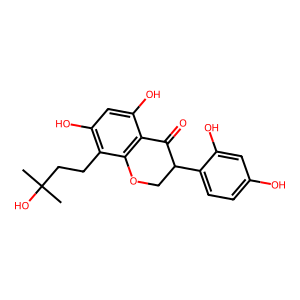

Prediction's cosine similarity to ground truth:  0.964678168296814
idx is  0
________retival #1, cosine similarity to prediction: 0.9646778702735901_________________
SMILES: CC(C)(O)CCc1c(O)cc(O)c2c1OCC(c1ccc(O)cc1O)C2=O
Name CHEBI:17529
Molecular weight 374.38900000000007


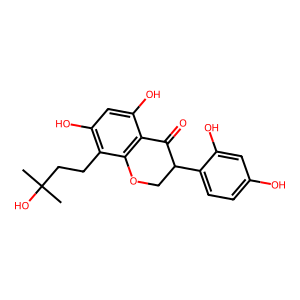

________retival #2, cosine similarity to prediction: 0.9052155017852783_________________
SMILES: CC(C)(O)CCc1c(O)ccc2c1OCC(c1ccc(O)cc1O)C2=O
Name 44257380
Molecular weight 358.3900000000001


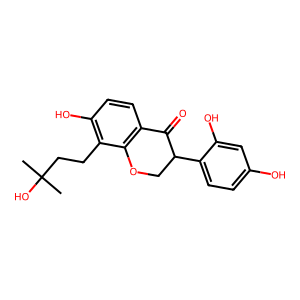

________retival #3, cosine similarity to prediction: 0.8162000179290771_________________
SMILES: CC(CO)CCc1c(O)cc(O)c2c1OCC(c1ccc(O)cc1O)C2=O
Name "3-(2,4-dihydroxyphenyl)-5,7-dihydroxy-8-(4-hydroxy-3-methyl-butyl)chroman-4-one"
Molecular weight 374.38900000000007


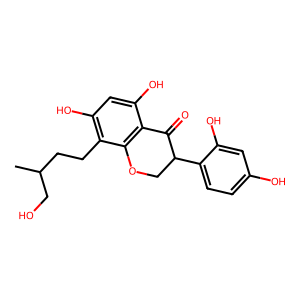

DONE






In [13]:
#### For infrastructure, this is cell can be skipped because i am not sharing my test-loader
'''
show some examples from my dataset to check sanity
for a single model, show top-5
'''

# for  which_compound in  random.sample(range(len(test_loader.dataset)), k=1):# range(0, 1):  
# for which_compound in range(0, 1):
for which_compound in range(1):
    
    print(f"############################################### compound number: {which_compound+1}##############################################################")
    
    for idx, batch in enumerate(test_loader):
        if idx < which_compound:
            continue
        inputs, extra_info = batch
        (smiles, names, NMR_type_indicator, path, np_class) = zip(*extra_info)
        # print(inputs.shape, inputs)
        # print(inputs, smiles_chemical_name)
        
        # batch[0] = batch[0].to("cuda")
        # hsqc, c_tensor, h_tensor = unpack_inputs_no_delimiter(inputs[0], NMR_type_indicator[0])
  
        inputs = inputs.to(model.device)
        NMR_type_indicator = NMR_type_indicator[0].to(model.device)
        pred = model(inputs, NMR_type_indicator)
        pred=torch.sigmoid(pred) # sigmoid
        pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)
        # print(pred_FP.nonzero().squeeze().tolist())
        break
    # print(f"dataloader: {loader_all_inputs.dataset.latest_element_got}")
    
    # print(inputs)
    
    print("Ground Truth NMR")
    # plot_NMR(hsqc, c_tensor, h_tensor)
    mw_from_input = inputs[0][-1][0].item()
    MW_filter = [mw_from_input*0.8, mw_from_input*1.2]
    print(f"MW filter: {MW_filter}")
    topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=3, filter_by_MW=MW_filter)
    # topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=4, filter_by_MW=None)
    # ground truth
    # smiles, names, path = zip(*smiles_chemical_name)
    mol = Chem.MolFromSmiles(smiles[0])
    print(f"Chemical name {names[0]}")
    print(f"Ground truth smiles {smiles[0]}")
    # print(f"Ground truth NMR path {path[0]}")
    img = Draw.MolToImage(mol)
    img.show()
    
    ground_truth_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(smiles[0])
    print("Prediction's cosine similarity to ground truth: ", compute_cos_sim(ground_truth_FP, pred.to("cpu").T.float()).item())
    # 
    i=0
    print("idx is ", idx)
    for value, (smile, name, mw , _), retrieved_FP in topk:
        print(f"________retival #{i+1}, cosine similarity to prediction: {value.item()}_________________")
        mol = Chem.MolFromSmiles(smile)
        # print("retrived FP", retrieved_FP.squeeze().tolist())

        print(f"SMILES: {smile}") 
        print(f"Name {name}")
        print(f"Molecular weight {mw}")
        img = Draw.MolToImage(mol)
        img.show()
        i+=1
        
print("DONE\n\n\n\n")
        



In [14]:
# '''
# temp feature:
# compute rank-1 on inference set
# '''
# from tqdm import tqdm

# rankingset_data = rankingset_data.to(model.device)
# # for  which_compound in  random.sample(range(len(test_loader.dataset)), k=1):# range(0, 1):  
# accu = [] 
    
# for idx, batch in tqdm(enumerate(test_loader)):
        
#     inputs, extra_info = batch
#     (smiles, names, NMR_type_indicator, path, np_class) = zip(*extra_info)
#     # print(inputs.shape, inputs)
#     # print(inputs, smiles_chemical_name)
    
#     # batch[0] = batch[0].to("cuda")
#     # hsqc, c_tensor, h_tensor = unpack_inputs_no_delimiter(inputs[0], NMR_type_indicator[0])

#     inputs = inputs.to(model.device)
#     NMR_type_indicator = NMR_type_indicator[0].to(model.device)
#     pred = model(inputs, NMR_type_indicator)
#     pred=torch.sigmoid(pred) # sigmoid
#     pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)

    
#     topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=1)
#     # ground truth
    
#     ground_truth_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(smiles[0])
#     # print("Prediction's cosine similarity to ground truth: ", compute_cos_sim(ground_truth_FP, pred.to("cpu").T.float()).item())
#     # 
#     i=0
#     for value, (smile, name, _, _), retrieved_FP in topk:
#         # print(f"________retival #{i+1}, cosine similarity to prediction: {value.item()}_________________")
#         # mol = Chem.MolFromSmiles(smile)
#         # # print("retrived FP", retrieved_FP.squeeze().tolist())

#         # print(f"SMILES: {smile}") 
#         # print(f"Name {name}")
#         # img = Draw.MolToImage(mol)
#         # img.show()
#         # i+=1
#         accu.append(smile == smiles[0])
#         # accu.append(pred_FP.nonzero().squeeze().tolist() == retrieved_FP.to_dense().nonzero().squeeze().tolist())
        
#         # accu.append(ground_truth_FP.nonzero().squeeze().tolist() == retrieved_FP.to_dense().nonzero().squeeze().tolist())
#     # if smile == smiles[0]:
#     #     break
    
# print("DONE\n\n\n\n")

# np.mean(accu)        



In [15]:
"""
Start  unkown compound
"""

'\nStart  unkown compound\n'

In [19]:
# look for the higher cos_sim possible in our dataset
def  retrieve_based_on_groudth(groud_truth_FP, k=5):
    topk = retrieve_top_k_by_rankingset(rankingset_data, groud_truth_FP, smiles_and_names, k=k) 
    
    i=0
    for ite, (value, (smile, name, _, _), retrieved_FP) in enumerate(topk):
        print(f"____________________________retival #{i+1}, cosine similarity: {value.item()}_____________________________")
        mol = Chem.MolFromSmiles(smile)
        print("retrived FP", retrieved_FP.to_dense().squeeze().tolist())
        print(f"SMILES: {smile}")
        print(f"Name {name}")
        #check is path file exists
        # plot_NMR(hsqc, c_tensor, h_tensor)
        img = Draw.MolToImage(mol)
        img.show()
        i+=1

In [17]:
Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"
Kavaratamide_A_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(Kavaratamide_A_SMILES)

newCompoundA_SMILES = "O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O"
newCompoundA_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(newCompoundA_SMILES)

Kavaratamide_A


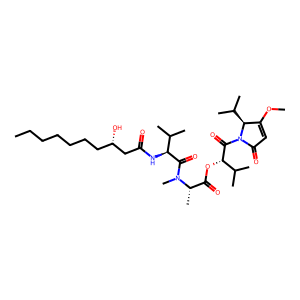

In [18]:
print("Kavaratamide_A")
mol = Chem.MolFromSmiles(Kavaratamide_A_SMILES)
img = Draw.MolToImage(mol)
img.show()

____________________________retival #1, cosine similarity: 0.70668625831604_____________________________
retrived FP [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.0, 0.0, 0.0, 0.0, 0.05773502215743065, 0.0, 0.0, 0.05773502215743065, 0.0, 0.0, 0.05773502215743065, 0.0, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05773502215743065, 0.0, 0.05773502215743065, 0.0, 0.0, 0.05773502215743065, 0.0, 0.0, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.0, 0.05773502215743065, 0.0, 0.05773502215743065, 0.0, 0.05773502

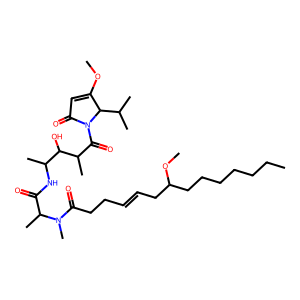

____________________________retival #2, cosine similarity: 0.622870922088623_____________________________
retrived FP [0.0, 0.0, 0.0, 0.0, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.0, 0.0, 0.0, 0.0, 0.05852057412266731, 0.0, 0.0, 0.05852057412266731, 0.0, 0.05852057412266731, 0.05852057412266731, 0.0, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.0, 0.0, 0.0, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.0, 0.0, 0.05852057412266731, 0.0, 0.0, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.0, 0.05852057412266731, 0.0, 0.0

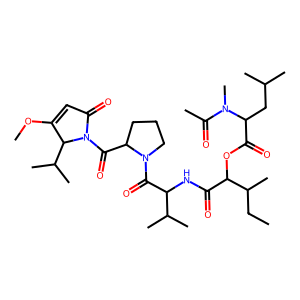

In [20]:
retrieve_based_on_groudth(Kavaratamide_A_FP.unsqueeze(dim=0).to("cuda"), k=2)




Kavaratamide A


_________________________________________________________
Prediction's cosine similarity to ground truth:  tensor(0.7138484120)



query shape:  torch.Size([6144]) torch.float32
________retival #1, cosine similarity to prediction: 0.649853527545929_________________
________retival's   cosine similarity to ground truth:  0.5081191062927246
SMILES: CCCCCCCC(C)CCCC(=O)C1=C(O)C(C)N(C)C1=O
Name ['54695884']


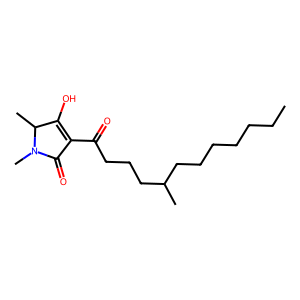

________retival #2, cosine similarity to prediction: 0.6445678472518921_________________
________retival's   cosine similarity to ground truth:  0.5024415850639343
SMILES: CCCCCCCCCC(C)CCCC(=O)C1=C(O)C(C)N(C)C1=O
Name ['54720038']


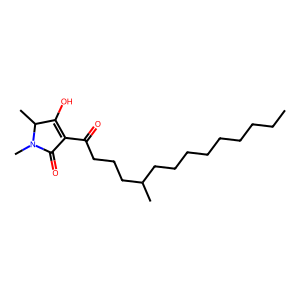

________retival #3, cosine similarity to prediction: 0.6418317556381226_________________
________retival's   cosine similarity to ground truth:  0.7066863775253296
SMILES: CCCCCCCC(CC=CCCC(=O)N(C)C(C)C(=O)NC(C)C(O)C(C)C(=O)N1C(=O)C=C(OC)C1C(C)C)OC
Name 934248-75-6


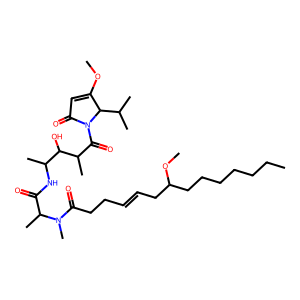

(['CCCCCCCC(C)CCCC(=O)C1=C(O)C(C)N(C)C1=O',
  'CCCCCCCCCC(C)CCCC(=O)C1=C(O)C(C)N(C)C1=O',
  'CCCCCCCC(CC=CCCC(=O)N(C)C(C)C(=O)NC(C)C(O)C(C)C(=O)N1C(=O)C=C(OC)C1C(C)C)OC'],
 [['54695884'], ['54720038'], '934248-75-6'])

In [ ]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/Kavaratamide A"
mode = None#"flip_sign"
inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=False, include_hsqc=True,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=3, mode = None, ground_truth_FP=Kavaratamide_A_FP,
                   fp_type = "MFP_Specific_Radius", filter_by_MW="from_input",
                #    weight_pred = torch.tensor(-specific_radius_mfp_loader.total_entropy_of_all_bits).to("cuda").float()
                )
                   

In [ ]:
def investigate_new_molecule(compound_dir, SMILES):
    return
    mode = None#"flip_sign"

    # for model_type in ["only_1d_DTD", "only_C-NMR_DTD"]:
    for model_type in ['All-NMR', 'HSQC', 'C-NMR', 'H-NMR', 'HSQC_C-NMR', 'HSQC_H-NMR', 'only_1d', "only_1d_DTD", "only_C-NMR_DTD"]:
    # for model_type in ['All-NMR']:
    # for model_type in ['C-NMR', ]:
        
        kwargs = {
            "include_h_nmr" : model_type in ['All-NMR', 'H-NMR', 'HSQC_H-NMR', 'only_1d', "only_1d_DTD"],
            "include_c_nmr" : model_type in ['All-NMR', 'C-NMR', 'HSQC_C-NMR', 'only_1d', "only_1d_DTD", "only_C-NMR_DTD"],
            "include_hsqc" : model_type in ['All-NMR', 'HSQC', 'HSQC_C-NMR', 'HSQC_H-NMR', ]
        }
        
        inputs, NMR_type_indicator = build_input(compound_dir, mode=mode, **kwargs)
        
        hparams, model, test_loader = choose_model_entropy_based_FP(model_type)
        max_radius = specific_radius_mfp_loader.max_radius
        print(f"Model type: {model_type}, max_radius: {max_radius}")
        rankingset_path = f"/root/gurusmart/MorganFP_prediction/inference_data/inference_rankingset_with_stable_sort/max_radius_{max_radius}_stacked_together_sparse/FP.pt"
        rankingset_data = torch.load(rankingset_path)#.to("cuda")
        
        save_molecule_inference(SMILES, compound_dir.split("/")[-1], None, model, model_type, inputs, NMR_type_indicator, rankingset_data, smiles_and_names)

In [ ]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/Kavaratamide A"
Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"

investigate_new_molecule(compound_dir, Kavaratamide_A_SMILES)

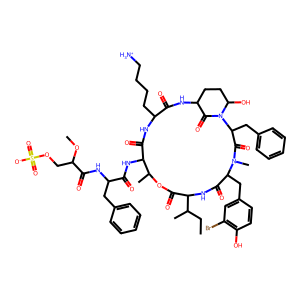

Error in O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O
Expecting value: line 1 column 1 (char 0)


(['unknown'], None)

In [ ]:
# retrieve_based_on_groudth(newCompoundA_FP.unsqueeze(dim=0).to("cuda"), k=5)
newCompoundA_SMILES = "O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O"
Draw.MolToImage(Chem.MolFromSmiles(newCompoundA_SMILES)).show()
get_superclass_and_glycoside(newCompoundA_SMILES)

____________________________retival #1, cosine similarity: 0.7940562963485718_____________________________
retrived FP [0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.0, 0.0, 0.0, 0.0, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.045501574873924255, 0.0, 0.045501574873924255, 0.0, 0.0, 0.045501574873924255, 0.0, 0.0, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.0, 0.0, 0.0, 0.0, 0.0, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.0455

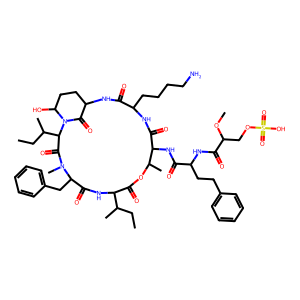

____________________________retival #2, cosine similarity: 0.7912123203277588_____________________________
retrived FP [0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0, 0.0, 0.0, 0.0, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.04476614

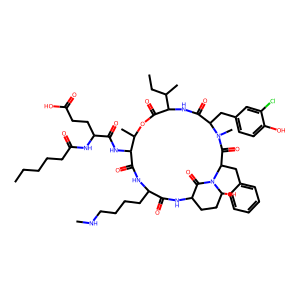

In [ ]:
retrieve_based_on_groudth(newCompoundA_FP.unsqueeze(dim=0).to("cuda"), k=2)




new_compound_A


_________________________________________________________
Prediction's cosine similarity to ground truth:  tensor(0.6962741017)



________retival #1, cosine similarity to prediction: 0.7390384674072266_________________
________retival's   cosine similarity to ground truth:  0.7940567135810852
SMILES: CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(C(C)CC)N2C(=O)C(CCC2O)NC(=O)C(CCCCN)NC(=O)C(NC(=O)C(CCc2ccccc2)NC(=O)C(COS(=O)(=O)O)OC)C(C)OC1=O
Name Oscillapeptin F


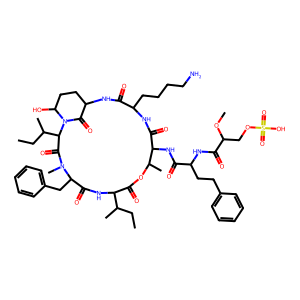

________retival #2, cosine similarity to prediction: 0.7365040183067322_________________
________retival's   cosine similarity to ground truth:  0.7166699171066284
SMILES: CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(C(C)O)N2C(=O)C(CCC2O)NC(=O)C(Cc2ccc(O)cc2)NC(=O)C(NC(=O)C(CCC(N)=O)NC(=O)C(O)Cc2ccc(O)cc2)C(C)OC1=O
Name 23724561


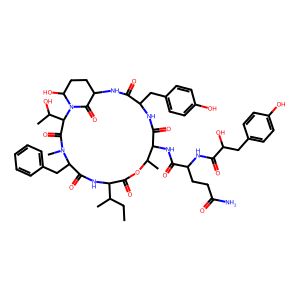

________retival #3, cosine similarity to prediction: 0.7350831031799316_________________
________retival's   cosine similarity to ground truth:  0.6990599632263184
SMILES: CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(C(C)O)N2C(=O)C(CCC2O)NC(=O)C(Cc2ccc(O)cc2)NC(=O)C(NC(=O)C(CCC(N)=O)NC(=O)C(NC(=O)C(O)Cc2ccc(O)cc2)C(C)O)C(C)OC1=O
Name 23724559


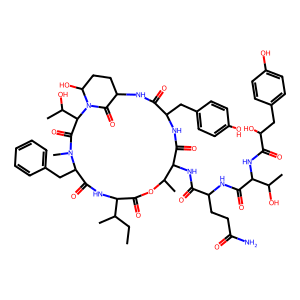

(['CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(C(C)CC)N2C(=O)C(CCC2O)NC(=O)C(CCCCN)NC(=O)C(NC(=O)C(CCc2ccccc2)NC(=O)C(COS(=O)(=O)O)OC)C(C)OC1=O',
  'CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(C(C)O)N2C(=O)C(CCC2O)NC(=O)C(Cc2ccc(O)cc2)NC(=O)C(NC(=O)C(CCC(N)=O)NC(=O)C(O)Cc2ccc(O)cc2)C(C)OC1=O',
  'CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(C(C)O)N2C(=O)C(CCC2O)NC(=O)C(Cc2ccc(O)cc2)NC(=O)C(NC(=O)C(CCC(N)=O)NC(=O)C(NC(=O)C(O)Cc2ccc(O)cc2)C(C)O)C(C)OC1=O'],
 ['Oscillapeptin F', '23724561', '23724559'])

In [ ]:
mode = None#"flip_sign"
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_A"

inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=False, include_hsqc=True,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=3, mode = None, ground_truth_FP=newCompoundA_FP, filter_by_MW="from_input",
                   fp_type = "MFP_Specific_Radius")

In [ ]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_A"
investigate_new_molecule(compound_dir, newCompoundA_SMILES)




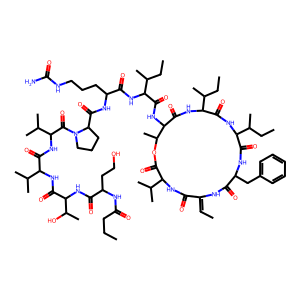

(['Oligopeptides'], False)

In [ ]:
new_compoundB_smiles = "CCC(C1C(NC(C(C)CC)C(NC(CC2=CC=CC=C2)C(N/C(C(NC(C(C)C)C(OC(C)C(NC(C(NC(C(NC(C3CCCN3C(C(NC(C(NC(C(NC(C(NC(CCC)=O)CCO)=O)C(O)C)=O)C(C)C)=O)C(C)C)=O)=O)CCCNC(N)=O)=O)C(CC)C)=O)C(N1)=O)=O)=O)=C\C)=O)=O)=O)C"
Draw.MolToImage(Chem.MolFromSmiles(new_compoundB_smiles)).show()
get_superclass_and_glycoside(new_compoundB_smiles)

____________________________retival #1, cosine similarity: 0.9056555032730103_____________________________
retrived FP [0.0, 0.0, 0.0, 0.0, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.0, 0.0, 0.0, 0.0, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0

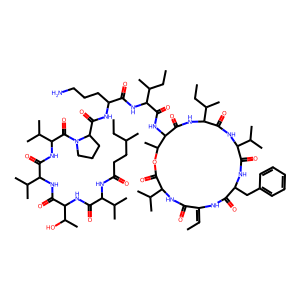

In [ ]:
newCompoundB_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(new_compoundB_smiles)
retrieve_based_on_groudth(newCompoundB_FP.unsqueeze(dim=0).to("cuda"), k=1)




new_compound_B1


_________________________________________________________
Prediction's cosine similarity to ground truth:  tensor(0.6181599498)



________retival #1, cosine similarity to prediction: 0.7940426468849182_________________
________retival's   cosine similarity to ground truth:  0.5906864404678345
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)CC)NC(=O)C(C(C)CC)NC(=O)C(C(C)O)NC(=O)C(CC(C)C)NC(=O)C(CCCN=C(N)N)NC(=O)C2CCCN2C(=O)C(C(C)C)NC(=O)C(C(C)C)NC(=O)C(C(C)O)NC(=O)C(C(C)OC(C)=O)NC(=O)C(C(C)C)NC1=O
Name Tolybyssidin A


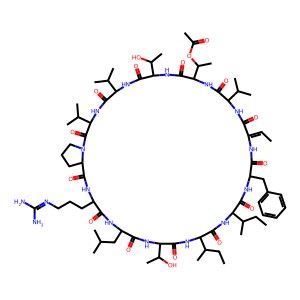

________retival #2, cosine similarity to prediction: 0.773648738861084_________________
________retival's   cosine similarity to ground truth:  0.5272873044013977
SMILES: CCC(C)C1NC(=O)C(CSSCC2NC(=O)C(Cc3ccccc3)NC(=O)C3CCCN3C(=O)C3CCCN3C(=O)C(C(C)C)NC(=O)C(C(C)CC)NC2=O)NC(=O)C(Cc2ccccc2)NC(=O)C2CCCN2C(=O)C2CCCN2C(=O)C(C(C)C)NC1=O
Name "(3~{S},9~{S},12~{S},15~{S},18~{S},21~{S})-18-benzyl-15-[[[(3~{S},9~{S},12~{S},15~{S},18~{S},21~{S})-18-benzyl-9-isopropyl-12-[(1~{S})-1-methylpropyl]-2,8,11,14,17,20-hexaoxo-1,7,10,13,16,19-hexazatricyclo[19.3.0.0^{3,7}]tetracosan-15-yl]methyldisulfanyl]methyl]-9-isopropyl-12-[(1~{S})-1-methylpropyl]-1,7,10,13,16,19-hexazatricyclo[19.3.0.0^{3,7}]tetracosane-2,8,11,14,17,20-hexone"


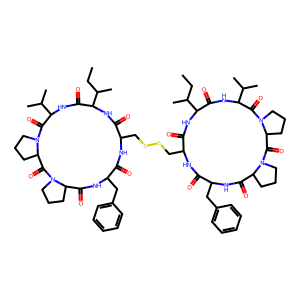

(['CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)CC)NC(=O)C(C(C)CC)NC(=O)C(C(C)O)NC(=O)C(CC(C)C)NC(=O)C(CCCN=C(N)N)NC(=O)C2CCCN2C(=O)C(C(C)C)NC(=O)C(C(C)C)NC(=O)C(C(C)O)NC(=O)C(C(C)OC(C)=O)NC(=O)C(C(C)C)NC1=O',
  'CCC(C)C1NC(=O)C(CSSCC2NC(=O)C(Cc3ccccc3)NC(=O)C3CCCN3C(=O)C3CCCN3C(=O)C(C(C)C)NC(=O)C(C(C)CC)NC2=O)NC(=O)C(Cc2ccccc2)NC(=O)C2CCCN2C(=O)C2CCCN2C(=O)C(C(C)C)NC1=O'],
 ['Tolybyssidin A',
  '"(3~{S},9~{S},12~{S},15~{S},18~{S},21~{S})-18-benzyl-15-[[[(3~{S},9~{S},12~{S},15~{S},18~{S},21~{S})-18-benzyl-9-isopropyl-12-[(1~{S})-1-methylpropyl]-2,8,11,14,17,20-hexaoxo-1,7,10,13,16,19-hexazatricyclo[19.3.0.0^{3,7}]tetracosan-15-yl]methyldisulfanyl]methyl]-9-isopropyl-12-[(1~{S})-1-methylpropyl]-1,7,10,13,16,19-hexazatricyclo[19.3.0.0^{3,7}]tetracosane-2,8,11,14,17,20-hexone"'])

In [ ]:
mode = None#"flip_sign"
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_B1"

inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=False, include_hsqc=True,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=2, mode = None, ground_truth_FP=newCompoundB_FP, filter_by_MW="from_input",
                   fp_type = "MFP_Specific_Radius")




new_compound_B2


_________________________________________________________
Prediction's cosine similarity to ground truth:  tensor(0.6738681197)



________retival #1, cosine similarity to prediction: 0.7387794852256775_________________
________retival's   cosine similarity to ground truth:  0.5272873044013977
SMILES: CCC(C)C1NC(=O)C(CSSCC2NC(=O)C(Cc3ccccc3)NC(=O)C3CCCN3C(=O)C3CCCN3C(=O)C(C(C)C)NC(=O)C(C(C)CC)NC2=O)NC(=O)C(Cc2ccccc2)NC(=O)C2CCCN2C(=O)C2CCCN2C(=O)C(C(C)C)NC1=O
Name "(3~{S},9~{S},12~{S},15~{S},18~{S},21~{S})-18-benzyl-15-[[[(3~{S},9~{S},12~{S},15~{S},18~{S},21~{S})-18-benzyl-9-isopropyl-12-[(1~{S})-1-methylpropyl]-2,8,11,14,17,20-hexaoxo-1,7,10,13,16,19-hexazatricyclo[19.3.0.0^{3,7}]tetracosan-15-yl]methyldisulfanyl]methyl]-9-isopropyl-12-[(1~{S})-1-methylpropyl]-1,7,10,13,16,19-hexazatricyclo[19.3.0.0^{3,7}]tetracosane-2,8,11,14,17,20-hexone"


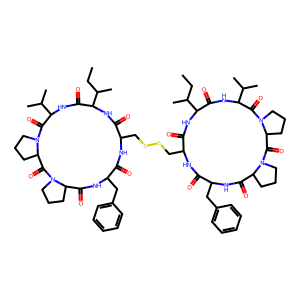

________retival #2, cosine similarity to prediction: 0.7213332653045654_________________
________retival's   cosine similarity to ground truth:  0.9056559801101685
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCC(C)CC)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name "(2~{R})-~{N}-[(1~{S})-4-amino-1-[[(1~{R},2~{S})-1-[[(3~{S},6~{Z},9~{S},12~{R},15~{R},18~{R},19~{R})-9-benzyl-6-ethylidene-3,12-diisopropyl-19-methyl-15-[(1~{S})-1-methylpropyl]-2,5,8,11,14,17-hexaoxo-1-oxa-4,7,10,13,16-pentazacyclononadec-18-yl]carbamoyl]-2-methyl-butyl]carbamoyl]butyl]-1-[(2~{R})-2-[[(2~{S})-2-[[(2~{S},3~{R})-3-hydroxy-2-[[(2~{R})-3-methyl-2-[[(4~{S})-4-methylhexanoyl]amino]butanoyl]amino]butanoyl]amino]-3-methyl-butanoyl]amino]-3-methyl-butanoyl]pyrrolidine-2-carboxamide"


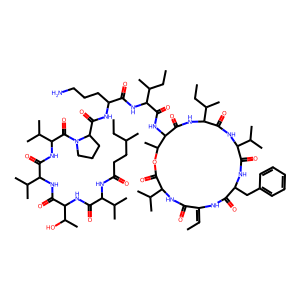

(['CCC(C)C1NC(=O)C(CSSCC2NC(=O)C(Cc3ccccc3)NC(=O)C3CCCN3C(=O)C3CCCN3C(=O)C(C(C)C)NC(=O)C(C(C)CC)NC2=O)NC(=O)C(Cc2ccccc2)NC(=O)C2CCCN2C(=O)C2CCCN2C(=O)C(C(C)C)NC1=O',
  'CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCC(C)CC)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O'],
 ['"(3~{S},9~{S},12~{S},15~{S},18~{S},21~{S})-18-benzyl-15-[[[(3~{S},9~{S},12~{S},15~{S},18~{S},21~{S})-18-benzyl-9-isopropyl-12-[(1~{S})-1-methylpropyl]-2,8,11,14,17,20-hexaoxo-1,7,10,13,16,19-hexazatricyclo[19.3.0.0^{3,7}]tetracosan-15-yl]methyldisulfanyl]methyl]-9-isopropyl-12-[(1~{S})-1-methylpropyl]-1,7,10,13,16,19-hexazatricyclo[19.3.0.0^{3,7}]tetracosane-2,8,11,14,17,20-hexone"',
  '"(2~{R})-~{N}-[(1~{S})-4-amino-1-[[(1~{R},2~{S})-1-[[(3~{S},6~{Z},9~{S},12~{R},15~{R},18~{R},19~{R})-9-benzyl-6-ethylidene-3,12-diisopropyl-19-methyl-15-[(1~{S})-1-methylpropyl]-2,5,8,11,14,17-hexaoxo-1-oxa-4,7,10,13,16-pentazacyclononadec-

In [ ]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_B2"

inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=False, include_hsqc=True,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=2, mode = None, ground_truth_FP=newCompoundB_FP, filter_by_MW="from_input",
                   fp_type = "MFP_Specific_Radius")

In [ ]:

specific_radius_mfp_loader.total_entropy_of_all_bits, specific_radius_mfp_loader.indices_kept

(array([-0.53068282, -0.53058171, -0.53053843, ..., -0.0631598 ,
        -0.0631598 , -0.0631598 ]),
 array([ 7485, 13629, 19773, ..., 13779, 20033, 29031]))

In [ ]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_B1"
# inputs, NMR_type_indicator = build_input(compound_dir,
#                      mode=mode,
#                      include_h_nmr=False, include_c_nmr=False
#                      )
# show_topK(inputs, k=3)

investigate_new_molecule(compound_dir, None)

In [ ]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_B2"


investigate_new_molecule(compound_dir, None)